* Name: `dissipation-theory--Study-9.ipynb`
* Author: John A. Marohn
* Date: 2023-10-03
* Continued from: `dissipation-theory--Study-7.ipynb`
* Continued to: `dissipation-theory--Study-10.ipynb`
* Reproduce the friction $\gamma_{\perp}$ versus charge density $\rho$ plots in Lekkala2013 Figure 9(b) using functions in `dissipationtheory.dissipation.py`.  Add in a low-density approximation.

# Preliminaries

In [1]:
from dissipationtheory.constants import ureg
from dissipationtheory.dissipation import CantileverModel, SampleModel2
from dissipationtheory.dissipation import CantileverModelJit, SampleModel2Jit
from dissipationtheory.dissipation import theta2norm_jit, gamma_perpendicular_jit, gamma_perpendicular_approx

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple

In [3]:
THIS = 'dissipation-theory--Study-9'

# Run simulations

We need a "jit" version of the sample for fast numerical calculations and a "regular" version of the sample for the approximation.

In [4]:
sample2_jit = SampleModel2Jit(
    cantilever=CantileverModelJit(81.0e3, 3.,  40E-9, 100E-9),
    epsilon_d=complex(3.4, -0.05),
    h_d=0,
    epsilon_s=complex(3.4, -0.05),
    mu=2.7E-10,
    rho=1e21,
    z_r=100E-9)

In [5]:
sample2 = SampleModel2(
    cantilever = CantileverModel(
        f_c = ureg.Quantity(81, 'kHz'), 
        V_ts = ureg.Quantity(3, 'V'), 
        R = ureg.Quantity(40, 'nm'), 
        d = ureg.Quantity(100, 'nm')),
    h_d = ureg.Quantity(0, 'nm'),
    epsilon_d = ureg.Quantity(complex(3.4, -0.05), ''),
    epsilon_s = ureg.Quantity(complex(3.4, -0.05), ''),
    mu = ureg.Quantity(2.7e-10, 'm^2/(V s)'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    z_r = ureg.Quantity(100, 'nm')
)

Print out the two samples to make sure they are the same.

In [10]:
sample2_jit.print()
sample2

cantilever
   cantilever freq =  81000.0 Hz
                   =  508938.0098815465 rad/s
tip-sample voltage =  3.0 V
            radius =  4e-08 m
            height =  1e-07 m

dielectric
 epsilon (real) =  3.4
 epsilon (imag) =  -0.5
      thickness =  0.0 m

semiconductor
          epsilon (real) =  3.4
          epsilon (imag) =  -0.5
               thickness = infinite
                mobility =  2.7e-10 m^2/(V s)
      diffusion constant =  6.980039959763987e-12 m^2/s
          charge density =  1e+27 m^{{-3}}
        reference height =  1e-07 m
            Debye length =  3.779777548184893e-11 m
        diffusion length =  3.7033649406515185e-09 m
effective epsilon (real) =  3.4
effective epsilon (imag) =  -9600.263628316976


cantilever

      resonance freq = 81.000 kHz
                     = 5.089e+05 rad/s
  tip-sample voltage = 3.000 V
              radius = 40.000 nm
              height = 100.000 nm

dielectric

  epsilon (real) = 3.400
  epsilon (imag) = -0.500
       thickness = 0.0 nm

semiconductor

             epsilon (real) = 3.400
             epsilon (imag) = -0.500
                  thickness = infinite
                   mobility = 2.70e-10 m^2/(V s)
         diffusion constant = 6.98e-12 m^2/s
             charge density = 1.00e+27 m^{-3}
           reference height = 100.0 nm
               Debye length = 0.0 nm
           diffusion length = 3.7 nm
   effective epsilon (real) = 3.400
   effective epsilon (imag) = -9600.264


Loop over the charge density $\rho$ and calculate approximate and exact answers for $\gamma_{\perp}$.

In [12]:
rho1 = ureg.Quantity(np.logspace(start=17, stop=27, num=50), '1/m^3')

data_sample2_jit = {}
data_approx = {}

keys = ['0.000','0.005','0.050','0.100','0.500']
for epsilonI_ in [0.000, 0.005, 0.050, 0.100, 0.500]:

    key = '{:0.3f}'.format(epsilonI_)

    sample2.epsilon_d = ureg.Quantity(complex(3.4, -1 * epsilonI_), '')
    sample2.epsilon_s = ureg.Quantity(complex(3.4, -1 * epsilonI_), '')
    
    rho__, gamma__ = gamma_perpendicular_approx(rho1, sample2)
    data_approx[key] = {'rho': rho__, 'gamma': gamma__ } 

    sample2_jit.epsilon_d = complex(3.4, -1 * epsilonI_)
    sample2_jit.epsilon_s = complex(3.4, -1 * epsilonI_)
    
    result2 = {
        'index': np.arange(len(rho1)),
        'rho': rho1,
        'gamma': ureg.Quantity(np.zeros_like(rho1), 'pN s/m')
    }
    
    for index, rho_ in enumerate(rho1):

        sample2_jit.rho = rho_.to('1/m^3').magnitude
        result2['gamma'][index] = gamma_perpendicular_jit(theta2norm_jit, sample2_jit).to('pN s/m')

    data_sample2_jit[key] = result2

Plot the results:

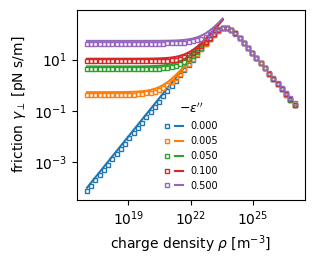

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize=(3.25, 2.75))

pA = {}
pB = {}

for index, key, c in zip(np.arange(len(keys)), keys, colors):

    opts = dict(markersize=3, fillstyle='none', linestyle='none', color=c)
    
    pA[index], = plt.loglog(data_sample2_jit[key]['rho'].to('1/m^3').magnitude,
                            data_sample2_jit[key]['gamma'].to('pN s/m').magnitude,
                            marker='s', **opts)

    pB[index], = plt.loglog(data_approx[key]['rho'].to('1/m^3').magnitude,
                            data_approx[key]['gamma'].to('pN s/m').magnitude,
                            '-', color=c)

plt.xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
plt.ylabel('friction $\gamma_{\perp}$ [pN s/m]')
ax1.legend(
    [(pA[0], pB[0]), (pA[1], pB[1]), (pA[2], pB[2]), (pA[3], pB[3]), (pA[4], pB[4])], 
    keys, 
    handler_map={tuple: HandlerTuple(ndivide=None)},
    frameon=False,
    fontsize=7,
    title_fontsize=9,
    title='$-\epsilon^{\prime\prime}$')

plt.tight_layout()

plt.savefig(THIS + '--Fig-2.png', dpi=300)
plt.savefig(THIS + '--Fig-2.pdf')

plt.show()

The plot compares simulations (squares) and a low-density approximation (lines) for various values of the imaginary part of the dielectric constant (legend).  The sample is similar to the one in Lekkala 2013 Figure9(b), but has $h_{\mathrm{d}} = 0$, so the sample corresponds to a semi-infinite dielectric slab.